---
title: "Practical Deep Learning, Lesson 5, Pricing Iowa Houses with Random Forests"
date: 2024-11-14T08:27:45-05:00
draft: false
tags:
- course.fast.ai
- language_models
series: "Fast.ai Course"
toc: true
github_url: https://github.com/danielcorin/fastbook_projects/tree/main/iowa_housing_prices
---

Having completed [lesson 5](https://course.fast.ai/Lessons/lesson5.html) of the FastAI course, I prompted Claude to give me some good datasets upon which to train a random forest model.
[This housing dataset](https://www.kaggle.com/datasets/emurphy/ames-iowa-housing-prices-dataset) from Kaggle seemed like a nice option, so I decided to give it a try.
I am also going to try something that Jeremy Howard recommended for this notebook/post, which is to not refine or edit my process very much.
I am mostly going to try things out and if they don't work, I'll try and write up why and continue, rather than finding a working path and adding commentary at the end.

To start, let's turn off warnings (for a cleaner notebook) and get the dataset from Kaggle.

In [4]:
import warnings
warnings.simplefilter('ignore', FutureWarning)

In [ ]:
!pip install kagglehub
!pip install --upgrade pip
!pip install fastai scikit-learn

In [5]:
import kagglehub

path = kagglehub.dataset_download("emurphy/ames-iowa-housing-prices-dataset")

print("Path to dataset files:", path)

Path to dataset files: /Users/danielcorin/.cache/kagglehub/datasets/emurphy/ames-iowa-housing-prices-dataset/versions/1


## Look at the data

We're going to look at the data first to try and understand it a bit better

In [6]:
import pandas as pd

df = pd.read_csv(str(path) + '/train1.csv', low_memory=False)

In [7]:
df.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

Lots of categorical variables.
Here are a few examples:

In [8]:
df['Fence'].unique()

array([nan, 'MnPrv', 'GdWo', 'GdPrv', 'MnWw'], dtype=object)

In [9]:
df['LandSlope'].unique()

array(['Gtl', 'Mod', 'Sev'], dtype=object)

In [10]:
df['HouseStyle'].unique()

array(['2Story', '1Story', '1.5Fin', '1.5Unf', 'SFoyer', 'SLvl', '2.5Unf',
       '2.5Fin'], dtype=object)

But also several continuous variables

<Axes: >

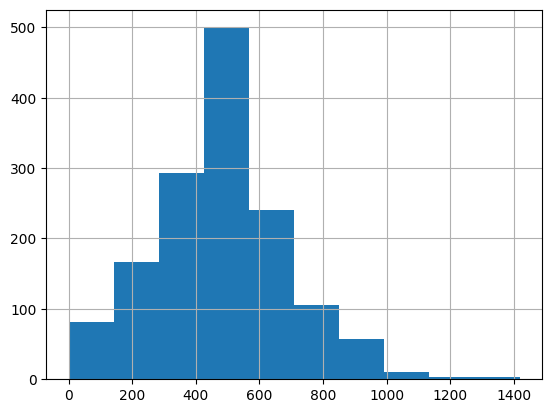

In [11]:
df['GarageArea'].hist()

<Axes: >

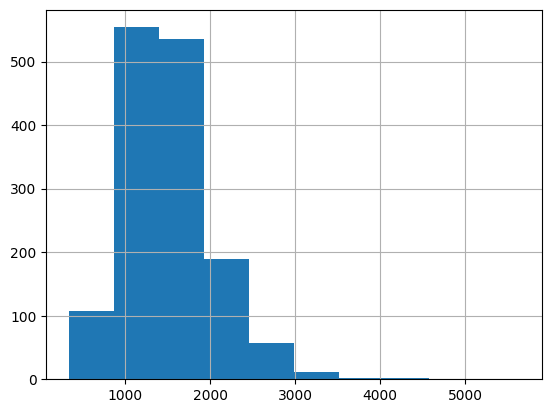

In [12]:
df['GrLivArea'].hist()

array([[<Axes: title={'center': '1stFlrSF'}>,
        <Axes: title={'center': '2ndFlrSF'}>]], dtype=object)

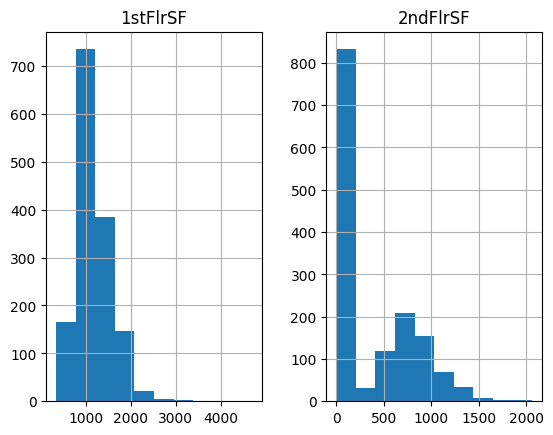

In [13]:
df[['1stFlrSF', '2ndFlrSF']].hist()

Since I'm not familiar with other approaches yet, I am going to use root mean square log error because that is what the [Chapter 9](https://github.com/fastai/fastbook/blob/master/09_tabular.ipynb) notebook uses.
If this approach doesn't produce an effective model, I'll investigate other approaches.

In [14]:
dep_var = 'SalePrice'
df[dep_var]

0       208500
1       181500
2       223500
3       140000
4       250000
         ...  
1455    175000
1456    210000
1457    266500
1458    142125
1459    147500
Name: SalePrice, Length: 1460, dtype: int64

In [15]:
import numpy as np

df[dep_var] = np.log(df[dep_var])
df[dep_var]

0       12.247694
1       12.109011
2       12.317167
3       11.849398
4       12.429216
          ...    
1455    12.072541
1456    12.254863
1457    12.493130
1458    11.864462
1459    11.901583
Name: SalePrice, Length: 1460, dtype: float64

Since we're aiming to predict home sale prices in the future, we should split our training and validation data by date.
Let's look at the range of the training set to figure out how it would make sense to do that.

Year range: 2006 - 2010


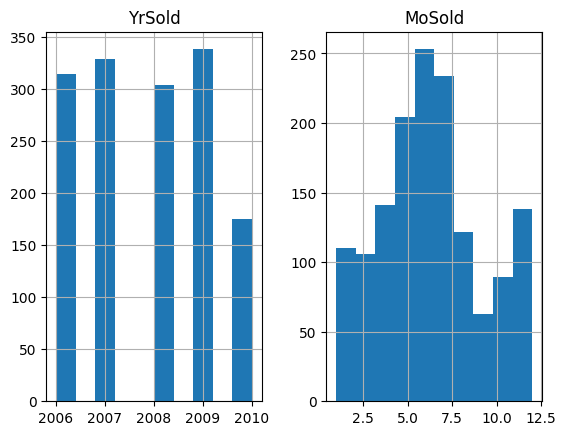

In [16]:
df[['YrSold', 'MoSold']].hist()
print(f"Year range: {df['YrSold'].min()} - {df['YrSold'].max()}")

## Create test and validation sets

I asked Claude how I might split these into training and validation sets (we'll see if this is helpful or even a good idea I guess).
It recommended a 75%-25% split between test and validation, so let's loosely do that.

In [18]:
cond = ((df['YrSold'] < 2009) | ((df['YrSold'] == 2009) & (df['MoSold'] >= 8))).values
train_idx = np.where(cond)[0]
valid_idx = np.where(~cond)[0]

splits = (list(train_idx),list(valid_idx))
print(f"Training set size: {len(train_idx)} ({len(train_idx)/len(df):.1%})")
print(f"Validation set size: {len(valid_idx)} ({len(valid_idx)/len(df):.1%})")

Training set size: 1061 (72.7%)
Validation set size: 399 (27.3%)


In [19]:
from fastai.tabular.all import *

cont, cat = cont_cat_split(df, 1, dep_var=dep_var)

In [20]:
procs = [Categorify, FillMissing]
to = TabularPandas(df, procs, cat, cont, y_names=dep_var, splits=splits)

After this data pre-processing, we validate the split is still approximately 75%-25%.

In [21]:
print(f"Training: {len(to.train)} ({len(to.train)/len(df):.1%})")
print(f"Validation: {len(to.valid)} ({len(to.valid)/len(df):.1%})")

Training: 1061 (72.7%)
Validation: 399 (27.3%)


## Create a decision tree

Following a similar approach to chapter 9, we're going to create a simple decision tree with a maximum of 4 leaf nodes so we can learn a bit about which features influence house sale prices the most.

In [22]:
xs, y = to.train.xs, to.train.y
valid_xs, valid_y = to.valid.xs, to.valid.y

In [23]:
from sklearn.tree import DecisionTreeRegressor

m0 = DecisionTreeRegressor(max_leaf_nodes=4)
m0.fit(xs, y);

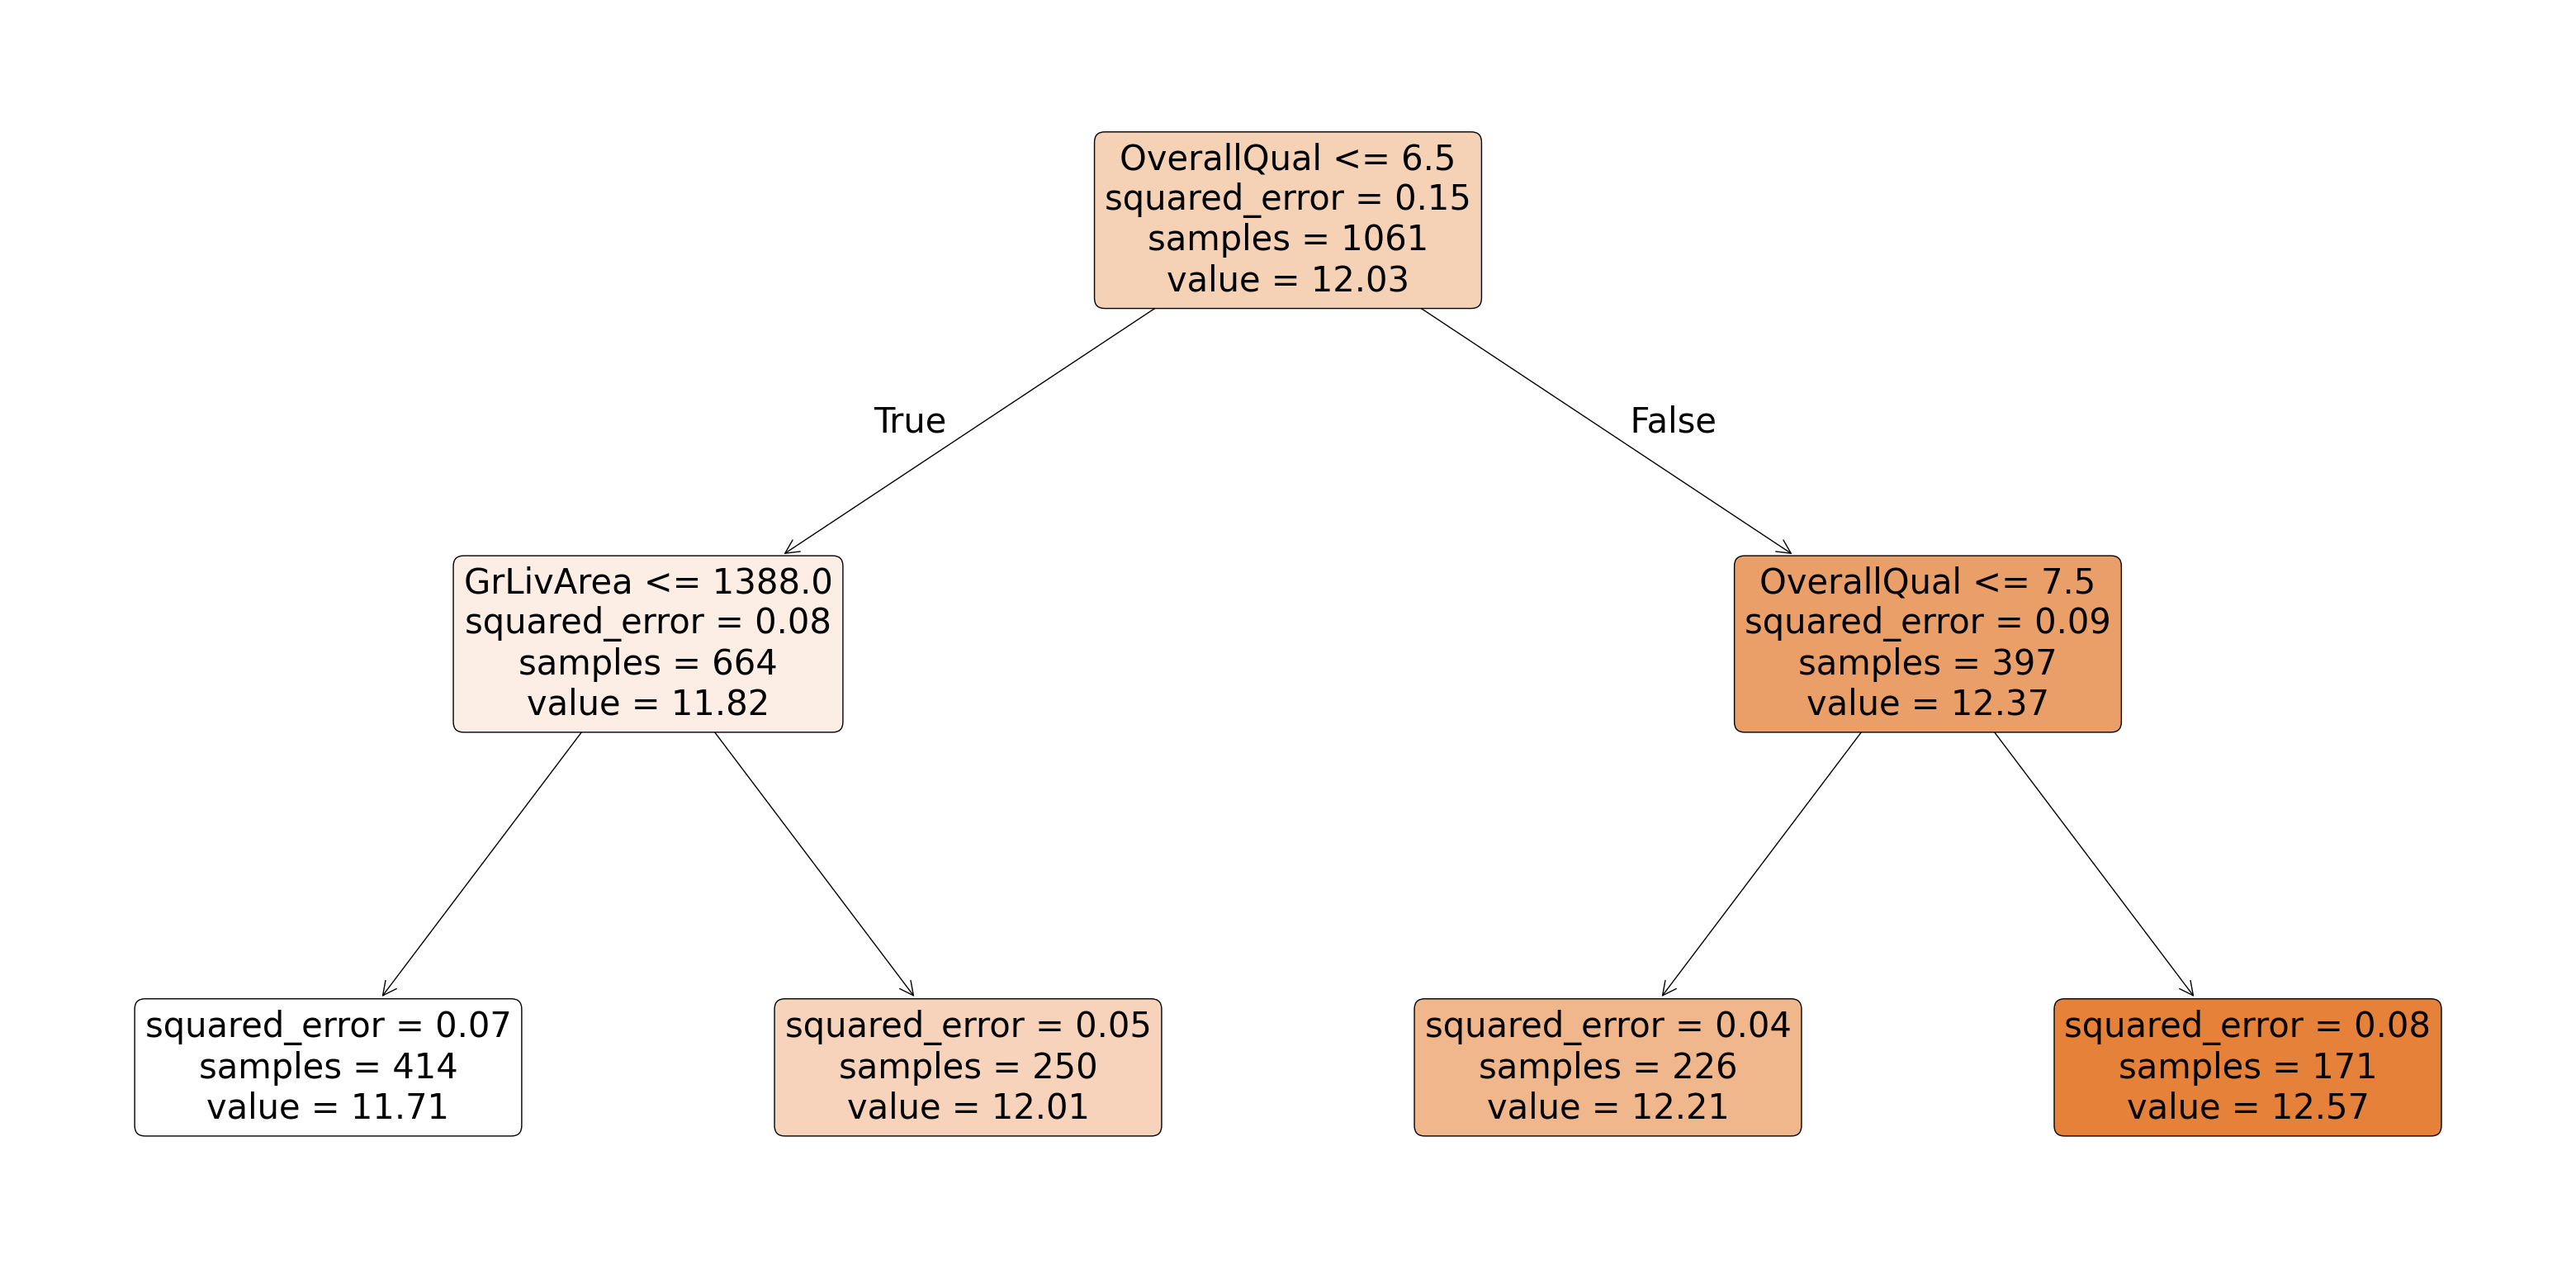

In [24]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

plt.figure(figsize=(40,20))
plot_tree(m0, feature_names=xs.columns, filled=True, rounded=True, precision=2, fontsize=30)
plt.show()

The `squared_error` looks a bit small but could be because we took the log of the sales prices.

In [ ]:
!pip install dtreeviz

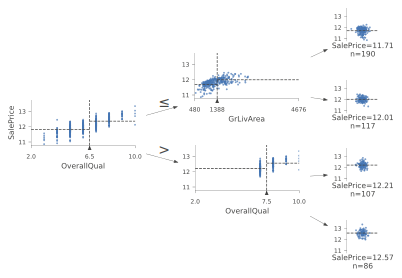

In [66]:
import dtreeviz
warnings.filterwarnings('ignore', 'X does not have valid feature names')


samp_idx = np.random.permutation(len(y))[:500]
viz_model = dtreeviz.model(
    m0,
    X_train=xs.iloc[samp_idx],
    y_train=y.iloc[samp_idx],
    feature_names=xs.columns,
    target_name=dep_var,
)

viz_model.view(
    fontname='DejaVu Sans',
    label_fontsize=10,
    orientation='LR',
)

Let's do the same experimentation in Chapter 9.
We'll build a bigger tree with no stopping criteria.

In [27]:
m1 = DecisionTreeRegressor()
m1.fit(xs, y);

In [28]:
def r_mse(pred,y): return round(math.sqrt(((pred-y)**2).mean()), 6)
def m_rmse(m, xs, y): return r_mse(m.predict(xs), y)

In [29]:
m_rmse(m1, xs, y)

0.0

A "perfect" model fit on the train data -- suspicious.

In [30]:
m_rmse(m1, valid_xs, valid_y)

0.223525

A pretty poor relative fit on the validation set

In [31]:
m1.get_n_leaves(), len(xs)

(np.int64(1019), 1061)

We're seeing almost as many leaves as training data points.
Let's try and build a smaller tree.

In [32]:
m2 = DecisionTreeRegressor(min_samples_leaf=25)
m2.fit(to.train.xs, to.train.y)
m_rmse(m2, xs, y), m_rmse(m2, valid_xs, valid_y)

(0.166169, 0.192442)

The root mean square error is a bit improved.

In [33]:
m2.get_n_leaves()

np.int64(33)

And with far fewer leaves!
Can a random forest improve our error rate further?

In [34]:
from sklearn.ensemble import RandomForestRegressor

def rf(xs, y, n_estimators, max_samples,
       max_features, min_samples_leaf, **kwargs):
    return RandomForestRegressor(
        n_jobs=-1,
        n_estimators=n_estimators,
        max_samples=max_samples,
        max_features=max_features,
        min_samples_leaf=min_samples_leaf,
        oob_score=True,
    ).fit(xs, y)

Let's inspect `xs` to figure out reasonable values for `n_estimators`, `max_samples`, `max_features` and `min_samples_leaf`.

In [35]:
print(f"n_samples: {len(xs)}")
print(f"n_features: {xs.shape[1]}")

n_samples: 1061
n_features: 83


Given these, I asked Claude for some reasonable values for these hyperparameters.

> n_estimators=100: Sweet spot between performance and training time
> 
> max_samples=33 (sqrt(1061))
> 
> max_features=9 (sqrt(83))
> 
> min_samples_leaf=11 (~1% of 1061)

I briefly looked to corroborate these suggestions in papers, but wasn't able to quickly do so.
I recognize these recommendations may be bad or wrong, but for learning purposes, I am going to proceed and we will see how it goes.

In [36]:
m3 = rf(xs, y, n_estimators=100,
        max_samples=33, max_features=9,
        min_samples_leaf=11)

In [37]:
m_rmse(m3, xs, y), m_rmse(m3, valid_xs, valid_y)

(0.279821, 0.302108)

Interesting. Worse results than our trees.

As the chapter does, let's plot `r_mse` as `n_estimators` varies in our model up to 125 to see if there is anything we can do to improve.

In [ ]:
preds = np.stack([t.predict(valid_xs) for t in m3.estimators_])

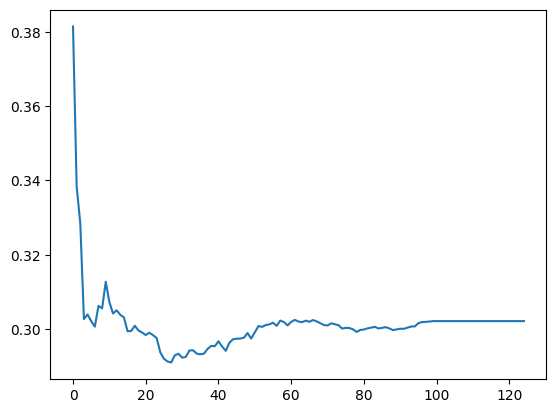

In [41]:
plt.plot([r_mse(preds[:i+1].mean(0), valid_y) for i in range(125)]);

I am going to chose 20 `n_estimators` because that looks like something close to the minimum.

In [42]:
m4 = rf(xs, y, n_estimators=20,
        max_samples=33, max_features=9,
        min_samples_leaf=11)

In [43]:
m_rmse(m4, xs, y), m_rmse(m4, valid_xs, valid_y)

(0.280595, 0.303637)

This hyperparameter change doesn't seem to improve the random forest model too much though.
Let's plot feature importance to see if we can learn more.

In [44]:
def rf_feat_importance(m, df):
    return pd.DataFrame(
        {'cols':df.columns, 'imp':m.feature_importances_}
    ).sort_values('imp', ascending=False)

In [45]:
fi = rf_feat_importance(m1, xs)
fi[:10]

,cols,imp
50,OverallQual,0.550081
62,GrLivArea,0.150868
58,TotalBsmtSF,0.081219
72,GarageCars,0.018286
52,YearBuilt,0.015654
57,BsmtUnfSF,0.013133
59,1stFlrSF,0.011235
55,BsmtFinSF1,0.011091
60,2ndFlrSF,0.010260
8,Neighborhood,0.009380


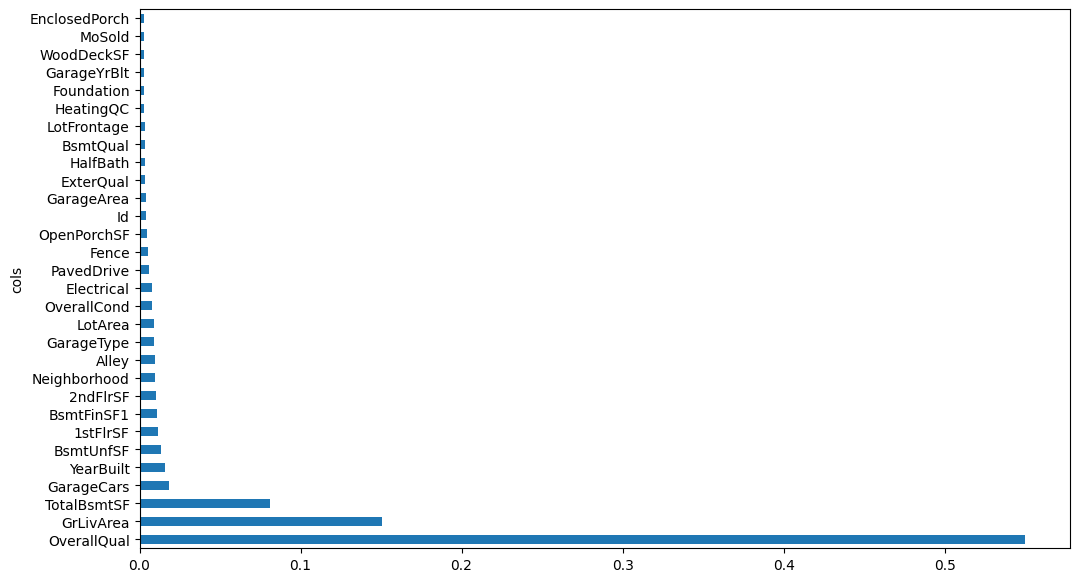

In [46]:
def plot_fi(fi):
    return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

plot_fi(fi[:30]);

It's interesting to see what I would guess is a subjective measure in `OverallQual` show up as the most impactful feature.

Following the chapter, let's remove the lower importance features and retrain the model with the pruned feature list.

In [47]:
to_keep = fi[fi.imp>0.005].cols
len(to_keep)

17

In [48]:
xs_imp = xs[to_keep]
valid_xs_imp = valid_xs[to_keep]

In [49]:
m5 = rf(xs_imp, y, n_estimators=15,
        max_samples=33, max_features=9,
        min_samples_leaf=11)

Now, let's train a model with the (supposedly) most important 18 features.

In [50]:
m_rmse(m5, xs_imp, y), m_rmse(m5, valid_xs_imp, valid_y)

(0.260041, 0.280743)

This turns out to be a bit of improvement with many fewer columns.

Let's look at the feature importance again and now and potentially redundant features.

In [51]:
len(xs.columns), len(xs_imp.columns)

(83, 17)

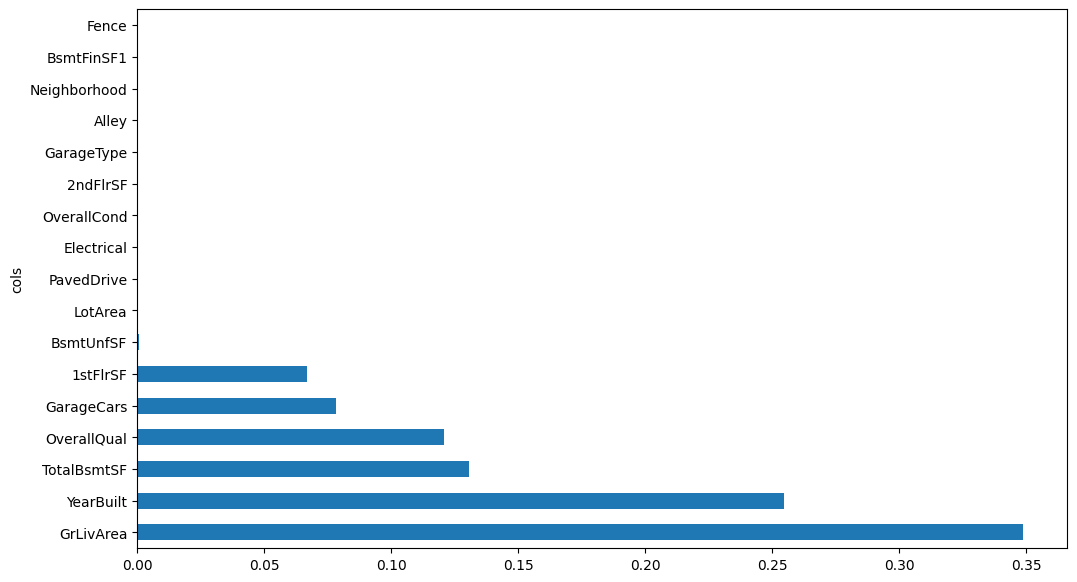

In [52]:
plot_fi(rf_feat_importance(m5, xs_imp));

It looks like maybe we could remove even more features?
I didn't expect to see so many features with such low importance.

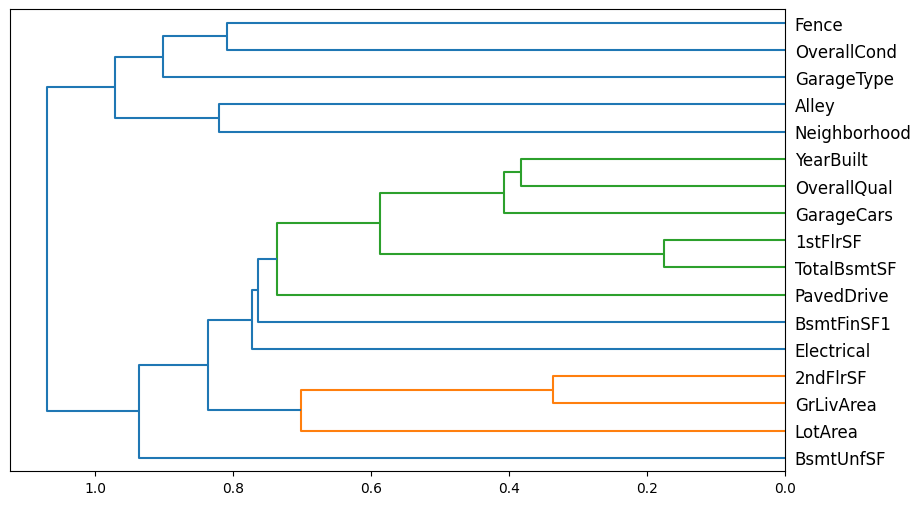

In [53]:
from scipy.cluster import hierarchy as hc

def cluster_columns(df, figsize=(10,6), font_size=12):
    corr = np.round(scipy.stats.spearmanr(df).correlation, 4)
    corr_condensed = hc.distance.squareform(1-corr)
    z = hc.linkage(corr_condensed, method='average')
    fig = plt.figure(figsize=figsize)
    hc.dendrogram(z, labels=df.columns, orientation='left', leaf_font_size=font_size)
    plt.show()

cluster_columns(xs_imp)

Nothing seems obviously duplicative.
Let's drop the remaining features with low importance seen in the feature importance plot, then train another model.

In [55]:
to_drop = [
    'Fence', 'BsmtFinSF1', 'Neighborhood', 'Alley', 'GarageType',
    '2ndFlrSF', 'OverallCond', 'Electrical', 'PavedDrive',
    'LotArea', 'BsmtUnfSF',
]
xs_final = xs_imp.drop(to_drop, axis=1)
valid_xs_final = valid_xs_imp.drop(to_drop, axis=1)

In [56]:
m6 = rf(xs_final, y, n_estimators=15,
        max_samples=33, max_features=9,
        min_samples_leaf=11)
m_rmse(m6, xs_final, y), m_rmse(m6, valid_xs_final, valid_y)

(0.254607, 0.271229)

Dropping these does not seem to make the model much worse.

## Run model on the test set

Let's load the test set and run our model to see if we're generally building the right direction.

In [57]:
test_df = pd.read_csv(str(path) + '/test1.csv', low_memory=False)
test_df[dep_var] = np.log(test_df[dep_var])

In [58]:
procs = [Categorify, FillMissing]
test_cont, test_cat = cont_cat_split(test_df, 1, dep_var=dep_var)
test_to = TabularPandas(test_df, procs, test_cat, test_cont, splits=None, y_names=None)

to_keep = xs_final.columns
test_xs = test_to.train.xs[to_keep]
preds = m6.predict(test_xs)
r_mse(preds, test_df[dep_var]), len(to_keep)

(0.22978, 6)

I think this result looks promising.
The error is a bit better than what we've seen during training.

I had some concerns removing so many of the features, but it does seemed to have improve the model at each turn, at least in training.
We can run a few of the older models against the test set to validate we're actually made improvements.


## Comparing to past models

On a limb, I decided to run the test set through all the models that I trained over the course of this notebook.

First, we run our random forest model after the first round of dropped features. 

In [59]:
to_keep = xs_imp.columns
test_xs = test_to.train.xs[to_keep]
preds = m5.predict(test_xs)
r_mse(preds, test_df[dep_var]), len(to_keep)

(0.190995, 17)

Next, we run our random forest with `n_estimators` hyperparameter tuning

In [60]:
to_keep = xs.columns
test_xs = test_to.train.xs[to_keep]
preds = m4.predict(test_xs)
r_mse(preds, test_df[dep_var]), len(to_keep)

(0.175185, 83)

After, we run our first random forest.

In [61]:
to_keep = xs.columns
test_xs = test_to.train.xs[to_keep]
preds = m3.predict(test_xs)
r_mse(preds, test_df[dep_var]), len(to_keep)

(0.175589, 83)

And finally, we run our first three tree models of varied `max_leaf_nodes` counts.

In [62]:
to_keep = xs.columns
test_xs = test_to.train.xs[to_keep]
preds = m2.predict(test_xs)
r_mse(preds, test_df[dep_var]), len(to_keep)

(0.359379, 83)

In [63]:
to_keep = xs.columns
test_xs = test_to.train.xs[to_keep]
preds = m1.predict(test_xs)
r_mse(preds, test_df[dep_var]), len(to_keep)

(0.412504, 83)

In [64]:
to_keep = xs.columns
test_xs = test_to.train.xs[to_keep]
preds = m0.predict(test_xs)
r_mse(preds, test_df[dep_var]), len(to_keep)

(0.315114, 83)

It looks like the fourth model (`m3`) we trained (our first random forest), which still considers all 83 of the original columns actually performs a bit better than our seventh model (`m6`) where we pruned many columns that didn't seem to have much importance.
However, given the number of columns we managed to prune, maybe it could make sense use the model with fewer considerations -- I'm not quite sure.
Maybe we could learn more by monitoring the model and retraining with new data in the future.

## Takeaways

I'm quite glad I kept a running log in the notebook as I experimented.
It made it very easy to go back and check my test set against previous model iterations.

So much experimentation is involved in building models and a notebook is a very useful tool that empowers the experimentation.
I'm not sure how I could do ML without them.

Claude continues to be an invaluable assistant for answering questions about my approach and writing little snippets of pandas to help me validate I am (hopefully) on the right track.

I'm still not really sure what my results mean!
My model seemed to perform reasonably well against the test set.
This (again) is where a Kaggle competition could help with a leaderboard so I could have some relative sense of how good my approach is.
Right now, I just don't know.
I've been told this feeling may never go away 🫠.